In [1]:
!pip install opencv-python==3.4.2.17


In [2]:
!pip install opencv-contrib-python==3.4.2.17

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm.notebook import tqdm
plt.rcParams['figure.figsize'] = [15, 15]

In [4]:
def img_read(path):
    img = cv2.imread(path)
    img_gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    return img_gray, img_rgb

In [5]:
left_gray, left_rgb = img_read('./left.jpg')
right_gray,  right_rgb = img_read('./right.jpg')

In [6]:
rows, cols = left_rgb.shape[:2]


In [8]:
def feautre_keypoints(img):
    siftDetector= cv2.xfeatures2d.SIFT_create() 

    k1, d1 = siftDetector.detectAndCompute(img, None)
    return k1, d1

In [9]:
k1, d1 = feautre_keypoints(left_gray)
k2, d2 = feautre_keypoints(right_gray)

In [10]:
def matcher(k1, d1, img1, k2, d2, img2, threshold):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(d1,d2, k=2)
    good_matches  = []
    for m,n in matches:
        if m.distance < threshold*n.distance:
            good_matches.append([m])

    matches = []
    for pair in good_matches:
        matches.append(list(k1[pair[0].queryIdx].pt + k2[pair[0].trainIdx].pt))

    all_matches = np.array(matches)
    return all_matches

In [11]:
matches = matcher(k1,d1, left_rgb, k2, d2, right_rgb, 0.8)

In [12]:
def compute_homography(pairs):
    rows = []
    for i in range(pairs.shape[0]):
        point1 = np.append(pairs[i][0:2], 1)
        point2 = np.append(pairs[i][2:4], 1)
        r1 = [0, 0, 0, point1[0], point1[1], point1[2], -point2[1]*point1[0], -point2[1]*point1[1], -point2[1]*point1[2]]
        r2 = [point1[0], point1[1], point1[2], 0, 0, 0, -point2[0]*point1[0], -point2[0]*point1[1], -point2[0]*point1[2]]
        rows.append(r1)
        rows.append(r2)
    total_r = np.array(rows)
    U, s, V = np.linalg.svd(total_r)
    H = V[-1].reshape(3, 3)
    H = H/H[2, 2] 
    return H

In [13]:
def random_point(mat, k=4):
    idx = random.sample(range(len(mat)), k)
    point = [mat[i] for i in idx ]
    return np.array(point)

In [14]:
def calculate_error(pts2, H):
    num_points = len(pts2)
    all_p1 = np.concatenate((pts2[:, 0:2], np.ones((num_points, 1))), axis=1)
    all_p2 = pts2[:, 2:4]
    ep2 = np.zeros((num_points, 2))
    for i in range(num_points):
        t = np.dot(H, all_p1[i])
        ep2[i] = (t/t[2])[0:2] 
    total_errors = np.linalg.norm(all_p2 - ep2 , axis=1) ** 2

    return total_errors

In [15]:
def ransac(matches, threshold, iters):
    inliers_tot = 0
    
    for i in range(iters):
        #points = random_point(matches)
        id = random.sample(range(len(matches)), 4)
        pts = [matches[i] for i in id]
        #convert to array 
        pts = np.asarray(pts)
        #compute homography 
        H = compute_homography(pts)
        
        if np.linalg.matrix_rank(H) < 3:
            continue
        errors = calculate_error(matches, H)
        idx = np.where(errors < threshold)[0]
        inliers = matches[idx]
        
        num_inliers = len(inliers)
        if num_inliers > inliers_tot:
            best_inliers = inliers.copy()
            inliers_tot = num_inliers
            best_H = H.copy()
            
    return best_inliers, best_H

In [ ]:
inliers, H = ransac(matches, 0.7, 5000)

In [17]:

def stitcher(img1, ref, H):

    H_inv = np.linalg.inv(H)
    h1, w1, c = img1.shape
    h2, w2, c = ref.shape
    min_x = float("inf")
    min_y = float("inf")
    max_x = float("-inf")
    max_y = float("-inf")
    c1 =  [(0,0), (h1, w1), (0, w1), (h1, 0)]
    c2 =  [(0,0), (h1, w1), (0, w1), (h1, 0)]
    for i,j in c1:
            x, y, w = np.matmul(H, [j , i, 1])
            x = x/w
            y = y/w
            if x > max_x:
                max_x = int(x)
            if x < min_x:
                min_x = int(x)
            if y > max_y:
                max_y = int(y)
            if y < min_y:
                min_y = int(y)
    warp_img = np.zeros((max_y - min_y,max_x - min_x, 3))
    for i in range(0, max_x - min_x):
        for j in range (0, max_y - min_y):
            x, y, w = np.matmul(H_inv, [i + min_x, j + min_y, 1])
            x = int(x/w)
            y = int(y/w)
            a = 0
            b = 0
            c = 0
            if not (y < 0 or y >= h1 or x < 0 or x >= w1):
                a, b, c = img1[y, x, :]
            warp_img[j, i, :] = [a/255, b/255, c/255]
    oldx = min_x
    oldy = min_y
    oldmx = max_x
    oldmy = max_y
    for i,j in c2:
        if j > max_x:
            max_x = int(j)
        if j < min_x:
            min_x = int(j)
        if i > max_y:
            max_y = int(i)
        if i < min_y:
            min_y = int(i)
    stitch_img = np.zeros(((max_y - min_y),(max_x - min_x), 3))
    for i in range(min_x, max_x):
        for j in range (min_y, max_y):
            a = 0
            b = 0
            c = 0
            if not (j < oldy or j >= oldmy or i < oldx or i >= oldmx):
                a, b, c = warp_img[j - oldy, i - oldx, :]
                if a == 0.0 or b == 0.0 or c == 0.0:
                    if not (j < 0 or j >= h2 or i < 0 or i >= w2):
                        a, b, c = ref[j, i, :]/255
            else:
                if not (j < 0 or j >= h2 or i < 0 or i >= w2):
                    a, b, c = ref[j, i, :]/255
            stitch_img[j - min_y, i- min_x, :] = [a, b, c]

    return  stitch_img

In [18]:
stitch_img = stitcher(left_rgb, right_rgb, H)

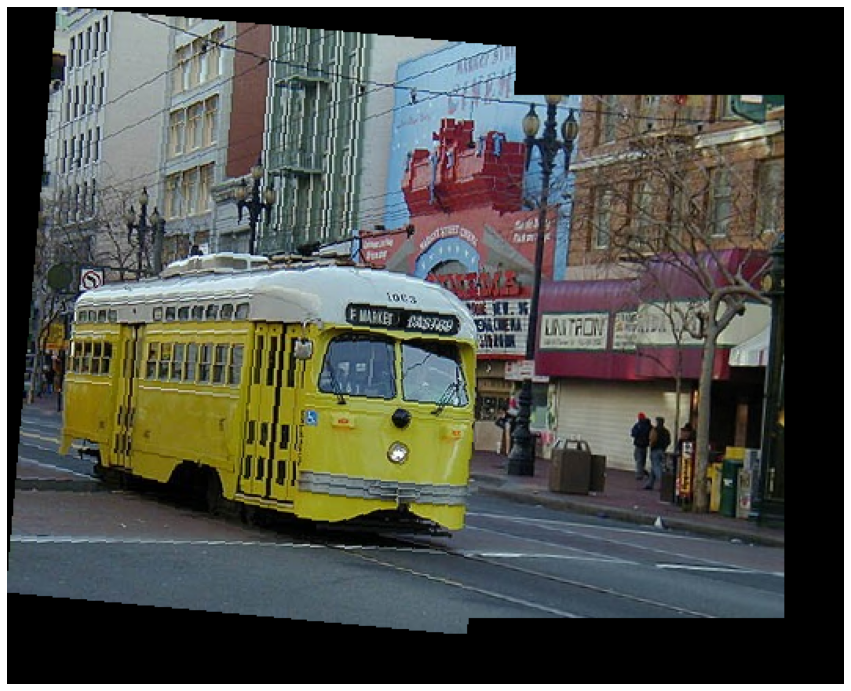

In [20]:
plt.axis('off')
plt.imshow(stitch_img)

plt.savefig('./stitch_bus.eps', format='eps',  bbox_inches='tight')
plt.savefig('./stitch_bus.jpg',  bbox_inches='tight')